# Various simulations related to the signature and the randomized signature with sigmoid additions

## Main notebook for simulating and testing

### Mechanism for Brownian Motion

In [79]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso

In [80]:
from timeit import default_timer as timer

In [81]:
import math

def sigmoid(x):
  return 1 / (1 + math.exp(-x))

sigm_v = np.vectorize(sigmoid)

In [82]:
class Brownian():
    """
    A Brownian motion class constructor
    """
    def __init__(self,x0=0):
        """
        Init class
        """
        assert (type(x0)==float or type(x0)==int or x0 is None), "Expect a float or None for the initial value"
        
        self.x0 = float(x0)
    
    def gen_random_walk(self,n_step=100):
        """
        Generate motion by random walk
        
        Arguments:
            n_step: Number of steps
            
        Returns:
            A NumPy array with `n_steps` points
        """
        # Warning about the small number of steps
        if n_step < 30:
            print("WARNING! The number of steps is small. It may not generate a good stochastic process sequence!")
        
        w = np.ones(n_step)*self.x0
        
        for i in range(1,n_step):
            # Sampling from the Normal distribution with probability 1/2
            yi = np.random.choice([1,-1])
            # Weiner process
            w[i] = w[i-1]+(yi/np.sqrt(n_step))
        
        return w
    
    def gen_normal(self,n_step=100):
        """
        Generate motion by drawing from the Normal distribution
        
        Arguments:
            n_step: Number of steps
            
        Returns:
            A NumPy array with `n_steps` points
        """
        if n_step < 30:
            print("WARNING! The number of steps is small. It may not generate a good stochastic process sequence!")
        
        w = np.ones(n_step)*self.x0
        
        for i in range(1,n_step):
            # Sampling from the Normal distribution
            yi = np.random.normal()
            # Weiner process
            w[i] = w[i-1]+(yi/np.sqrt(n_step))
        
        return w

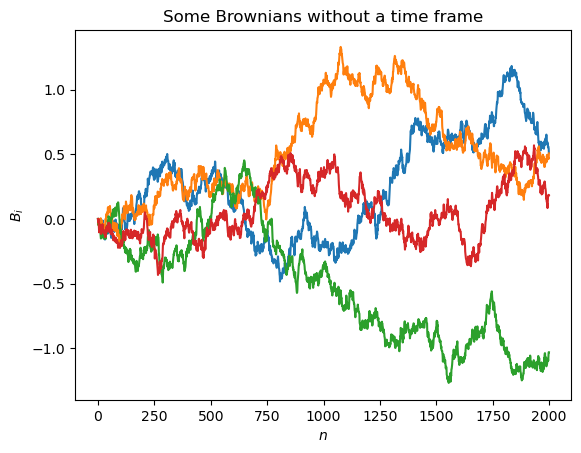

In [83]:
b = Brownian()
for i in range(4):
    plt.plot(1*b.gen_normal(2000))

plt.title("Some Brownians without a time frame")
plt.xlabel("$n$")
plt.ylabel("$B_i$")
plt.show()

### Defining the functions to test later:

In [84]:
id_v = np.vectorize(lambda a : a)
g1 = id_v
sq_v =  np.vectorize(lambda a : a*a)
g2 = sq_v
cu_v =  np.vectorize(lambda a : a*a*a)
g3 = cu_v
quo_v =  np.vectorize(lambda a : 1/(1+abs(a)))
g4 = quo_v
sqrt_v = np.vectorize(math.sqrt)
log_v = np.vectorize(math.log)
sin_v = np.vectorize(math.sin)
g5 = sin_v 
cos_v = np.vectorize(math.cos)
arctan_v = np.vectorize(np.arctan)
g6 = arctan_v

### Time and step structure

In [85]:
N = 201
T = 1
step = T/N
x_axis = np.linspace(0, T, N)

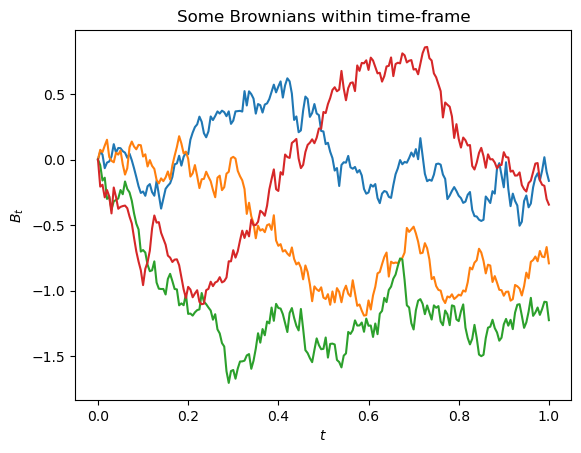

In [86]:
for i in range(4):
    plt.plot(x_axis, b.gen_normal(N))
plt.title("Some Brownians within time-frame")
plt.xlabel("$t$")
plt.ylabel("$B_t$")
plt.show()

## 1-Dimensional Stochastic Double Well

Let us consider the one-dimensional stochastic Double Well process, given by

\begin{equation}
    dX_t = \theta X_t (\mu - X_t^2)dt + \rho d B_t, \ X_0 = x_0 \in \mathbb{R}, \ t \in [0,1],
\end{equation}

where $B_t$ is a 1-dimensional Brownian motion, and $( \mu, \theta, \rho) \in \mathbb{R} \times \mathbb{R}^+ \times \mathbb{R}^+$.

### Time and step structure

In [87]:
N = 1001
T = 1
step = T/N
x_axis = np.linspace(0, T, N)

### Constructing the Double Well process

In [88]:
b = Brownian()

theta, mu, sigma, y0 = 1, 2, 1, 1
Y = np.zeros(N)
Y[0] = y0
brow = b.gen_normal(N+1)
db =  np.diff(brow)

In [89]:
for i in range(N-1):
    Y[i+1] = Y[i] + theta * Y[i] * (mu - Y[i]*Y[i]) * step + sigma * db[i]

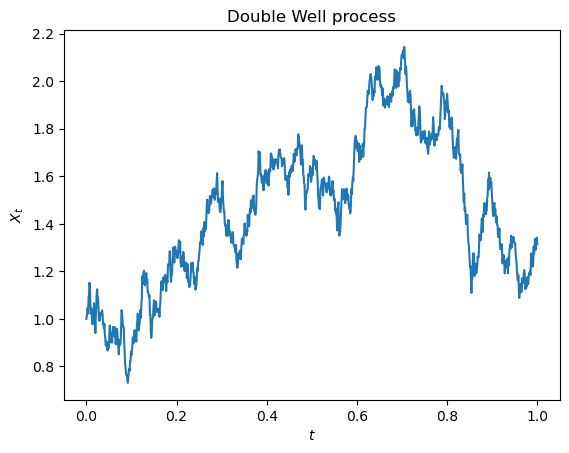

In [90]:
plt.plot(x_axis, Y)
plt.title("Double Well process")
plt.xlabel("$t$")
plt.ylabel("$X_t$")
plt.show()

### Constructing the randomized signature

For any $k \in \mathbb{N}$ big enough and appropriately
chosen random matrices $A_1,...,A_d$ in $\mathbb{R}^{k \times k}$ and random shifts $b_1,...,b_d$ in $\mathbb{R}^{k \times 1}$, and any fixed activation function $\sigma$ (notice that we explicitly allow the identity as a possible choice here), the solution of
\begin{equation}
    d Z_t(X) = \sum_{i=1}^d \sigma (A_iZ_t(X) + b_i)d X^i_t, \; Z_0(X) = (1,0,...,0) \in \mathbb{R}^k, \; t \in [0,T] \label{rand_sig_first}
\end{equation}
is called the randomized signature of $X$.



Here, we initialize $A_i \in \mathbb{R}^{k \times k}, b_i \in \mathbb{R}^k$ to have i.i.d. standard normal entries and set the sigmoid function $\sigma(x) := \frac{1}{1+e^{-x}}$.

In [91]:
k = 30
A = np.random.normal(0, 1, size=(k, k))
b = np.random.normal(0, 1, size=k)
dY = np.diff(Y)
Z = np.zeros((N, k))
Z[0][0] = 1

##### With sigmoid

In [92]:
for i in range(N-1):
    Z[i+1] =   Z[i] + sigm_v(A@Z[i] + b)*dY[i] 

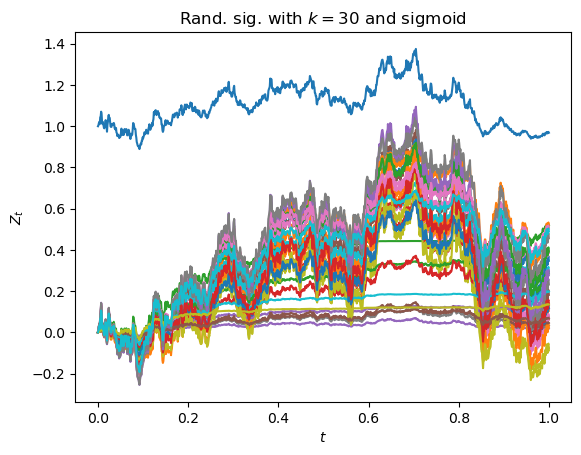

In [93]:
for i in range(30):
    plt.plot(x_axis, Z[:,i])

plt.title("Rand. sig. with $k = 30$ and sigmoid")
plt.xlabel("$t$")
plt.ylabel("$Z_t$")
plt.show()

### Just a sanity check - Training the linear, time-homogeneous readout for just one sample

In [94]:
target_func = g1

In [95]:
target = target_func(Y)

In [96]:
model1 = LinearRegression().fit(Z, target)

In [97]:
r_sq_1 = model1.score(Z,target)
print(f"coefficient of determination: {r_sq_1}")

coefficient of determination: 0.9999999999967023


In [98]:
print(f"intercept: {model1.intercept_}")

intercept: 1.0314192889540934


In [99]:
print(f"coefficients: {model1.coef_}")

coefficients: [-0.03142107  0.07767939  0.00096171 -0.02521299  0.16461088  0.12099498
 -0.03596117  0.04094901  0.0329039   0.05036118  0.00757994  0.01082711
  0.05927312 -0.01567893  0.24433991  0.11156234  0.07908577  0.05175225
  0.00568408  0.00574349 -0.02278559 -0.03860542  0.04669356 -0.04085712
  0.74572409 -0.07118783 -0.07008313 -0.00696294  0.03924406  0.0358715 ]


In [100]:
Y_pred_1 = model1.predict(Z)

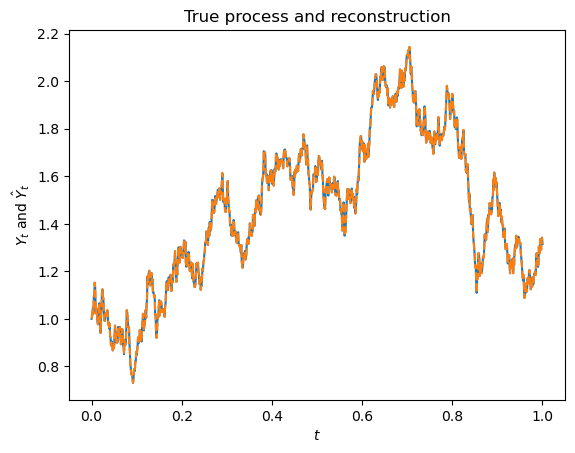

In [101]:
plt.plot(x_axis, target)
plt.plot(x_axis, Y_pred_1, '--')
plt.title("True process and reconstruction")
plt.xlabel("$t$")
plt.ylabel("$Y_t$ and $\hat{Y}_t$")
plt.show()

### Simulating n_sim times and testing out of sample - $g_1$ to $g_6$

First, we define the following functions for a general $x \in \mathbb{R}$:
\begin{align}
     & g_1(x) = x \\ \nonumber
     & g_2(x) = x^2 \\ \nonumber
    & g_3(x) = x^3 \\ \nonumber
    & g_4(x) = \frac{1}{1+|x|} \\ \nonumber
    & g_5(x) = sin(x) \\ \nonumber
    & g_6(x) = arctan(x).
\end{align}

Furthermore, we fix $x_0=1, \mu = 2, \theta = 1, \rho = 1$ for the process and $N_{train}=200, N_{test}=100, N_{steps}=1001, \lambda_{ridge}=0.01$ for the training procedure. We will vary different choices of $k$, the dimension of the randomized signature.

As presented in the theoretical part, the idea is to find a $W \in \mathbb{R}^{1 \times k}$, such that $g_i (X_t) \approx W Z_t, i \in \{1, ..., 6\}$, where $Z_t$ is the $k$-dimensional randomized signature value of $X_t$.

We simulate $X_t$ $N_{train}$ times, compute the corresponding $Z_t$ and create a training set of size $N_{train} \times N_{steps}$ (every time step of every simulation). Then, we train a ridge regression with regularization parameter $\lambda_{ridge}$ between the $Z_t$'s and $g_i(X_t)$'s from the training set.

Finally, we simulate new, unseen $N_{test}$ samples and compare the values of $g_i(X_t)$ and $\hat{g_i}(X_t) := WZ_t$, where $W \in \mathbb{R}^{1 \times k}$ is the learned linear readout via ridge regression. We compute the error in terms of an average relative $L^2$ error over all $N_{test}$ samples. The dimensionality parameter $k$ is varied from the set $\{ 10, 20, 50, 100, 200 \}$. The best performing choice is highlighted in the results.

#### Set the target function:

In [102]:
target_func = g5

#### Set the training parameters:

In [103]:
n_sim = 200
k = 20
A = np.random.normal(0, 1, size=(k, k))
b = np.random.normal(0, 1, size=k)
Y_big = np.zeros(N*n_sim)
target_big = np.zeros(N*n_sim)
Z_big = np.zeros((N*n_sim, k))
Y_big[0:N,] = np.ones(N)
Z_big[0:N,].shape

(1001, 20)

In [104]:
for iter in range(n_sim):

    br = Brownian()
    Y = np.zeros(N)
    Y[0] = y0
    brow = br.gen_normal(N+1)
    db =  np.diff(brow)
    for i in range(N-1):
        Y[i+1] = Y[i] + theta * Y[i] * (mu - Y[i]*Y[i]) * step + sigma * db[i]
    dY = np.diff(Y)
    Z = np.zeros((N, k))
    Z[0][0] = 1
    for i in range(N-1):
        Z[i+1] = Z[i] + sigm_v(A@Z[i] + b)*dY[i]
    Y_big[iter*N:(iter+1)*N] = Y
    Z_big[iter*N:(iter+1)*N,:] = Z
    
    target = target_func(Y)
    target_big[iter*N:(iter+1)*N] = target

In [105]:
model3 = Ridge(alpha=0.01)
model3.fit(Z_big, target_big)

Ridge(alpha=0.01)

In [106]:
r_sq_3 = model3.score(Z_big, target_big)
print(f"coefficient of determination: {r_sq_3}")

coefficient of determination: 0.9314874491446041


In [107]:
print(f"intercept: {model3.intercept_}")

intercept: 1.157000943095129


In [108]:
print(f"coefficients: {model3.coef_}")

coefficients: [-0.43403986  0.20883953 -0.34355499  0.15648916 -1.78056383  4.76365879
 -0.776183   -4.58378675  1.08646401  2.12146623 -1.14226517 -2.25060193
 -0.97185933  1.53783742 -0.79872235  0.3864453   0.14741024  1.42009821
 -2.77686271  1.53251486]


#### Set the testing parameters:

In [109]:
n_test = 100

In [110]:
error_list = []
for i_test in range(n_test):    
    br = Brownian()
    Y = np.zeros(N)
    Y[0] = y0
    brow = br.gen_normal(N+1)
    db =  np.diff(brow)
    for i in range(N-1):
        Y[i+1] = Y[i] + theta * Y[i] * (mu - Y[i]*Y[i]) * step + sigma * db[i]
    dY = np.diff(Y)
    Z = np.zeros((N, k))
    Z[0][0] = 1
    for i in range(N-1):
        Z[i+1] = Z[i] + sigm_v(A@Z[i] + b)*dY[i]
    target = target_func(Y)
    Y_pred_3 = model3.predict(Z)
    error_list.append(np.linalg.norm(target-Y_pred_3)/np.linalg.norm(target))

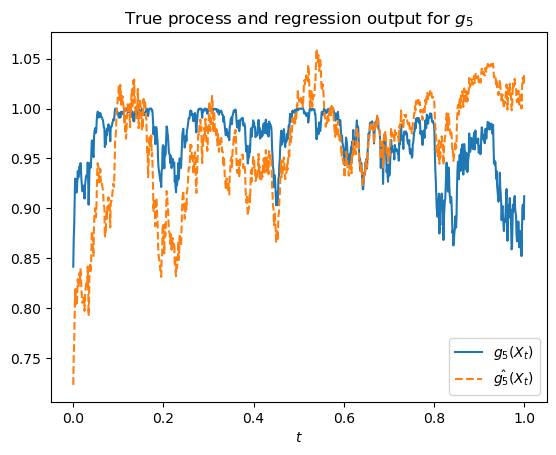

In [111]:
plt.plot(x_axis, target)
plt.plot(x_axis, Y_pred_3, '--')
plt.title("True process and regression output for $g_5$")
plt.xlabel("$t$")
plt.gca().legend(('$g_5(X_t)$','$\hat{g_5}(X_t)$'))
plt.show()

### The average $L^2$ error

In [112]:
np.mean(error_list)

0.08818562099854439

## 4-Dimensional Ornstein–Uhlenbeck process

### Time and step structure

In [113]:
N = 101
T = 1
step = T/N
x_axis = np.linspace(0, T, N)

We now turn to a multidimensional control setup. We recall that the dynamics of the four-dimensional stochastic Ornstein–Uhlenbeck process is given by

\begin{equation}
    dX_t = (\mu - \Theta X_t)dt + \Sigma d B_t, \ X_0 = x_0 \in \mathbb{R}^4, \ t \in [0,1],
\end{equation}

where $B_t$ is a four-dimensional Brownian motion, and $(\mu,\Theta,\Sigma) \in \mathbb{R}^4 \times \mathbb{R}^{4 \times 4} \times \mathbb{R}^{4 \times 4}$.

### Constructing the  Ornstein–Uhlenbeck  process

In [114]:
y0_4, mu_4 = np.array([1,1,1,1]), np.array([1,1,1,1])
sigma_4 = np.array([[1,0,0,0], [0,1,0,0], [0,0,1,0], [0,0,0,1]])
theta_4 = np.array([[1,1/2,1/3,1/4], [2,1,2/3,2/4], [3,3/2,1,3/4], [4,2,4/3,1]])
Y_4 = np.zeros((N,4))
Y_4[0] = y0_4
brow_4 = np.zeros((N+1,4))
#sigma_4 = theta_4

In [115]:
br_4 = Brownian()

for i in range(4):
    brow_4[:,i] = br_4.gen_normal(N+1)
db_4 = np.diff(brow_4, axis = 0)

In [116]:
for i in range(N-1):
    Y_4[i+1] = Y_4[i] + (mu_4 - theta_4 @ Y_4[i]) * step + sigma_4 @ db_4[i]

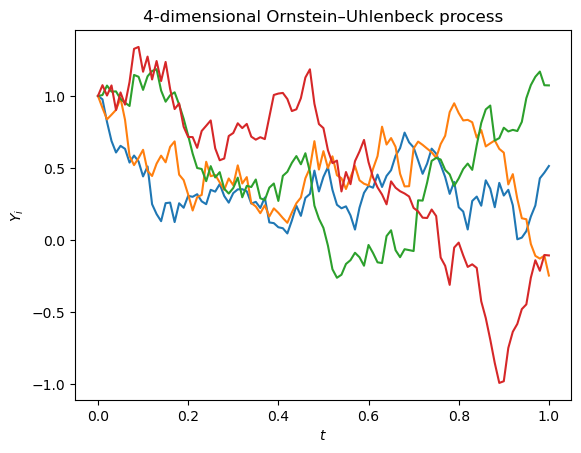

In [117]:
for i in range(4):
    plt.plot(x_axis, Y_4[:,i])

plt.title("4-dimensional Ornstein–Uhlenbeck process")
plt.xlabel("$t$")
plt.ylabel("$Y_i$")
plt.show()

### Constructing the randomized signature

For any $k \in \mathbb{N}$ big enough and appropriately
chosen random matrices $A_1,...,A_d$ in $\mathbb{R}^{k \times k}$ and random shifts $b_1,...,b_d$ in $\mathbb{R}^{k \times 1}$, and any fixed activation function $\sigma$ (notice that we explicitly allow the identity as a possible choice here), the solution of
\begin{equation}
    d Z_t(X) = \sum_{i=1}^d \sigma (A_iZ_t(X) + b_i)d X^i_t, \; Z_0(X) = (1,0,...,0) \in \mathbb{R}^k, \; t \in [0,T] \label{rand_sig_first}
\end{equation}
is called the randomized signature of $X$.



In [118]:
k_4 = 30
A_4 = np.random.normal(0, 1, size=(4, k_4, k_4))
b_4 = np.random.normal(0, 1, size=(4,k_4))
dY_4 = np.diff(Y_4, axis = 0)
Z_4 = np.zeros((N, k_4))
Z_4[0][0] = 1

In [119]:
for i in range(N-1):
    auxiliary = 0
    for j in range(4):
        auxiliary += sigm_v(A_4[j]@Z_4[i] + b_4[j])*dY_4[i][j]
    Z_4[i+1] = Z_4[i] + auxiliary

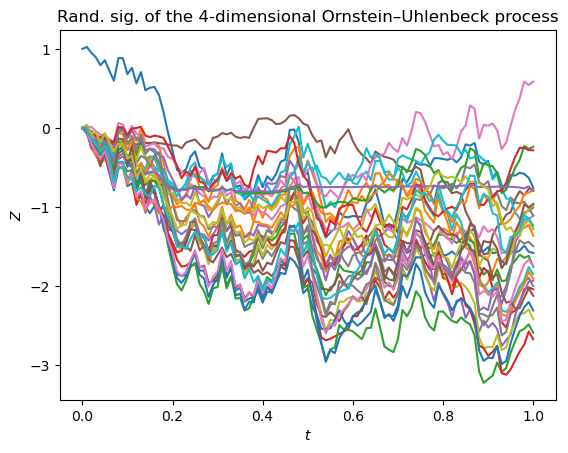

In [120]:
for i in range(k_4):
    plt.plot(x_axis, Z_4[:,i])

plt.title("Rand. sig. of the 4-dimensional Ornstein–Uhlenbeck process")
plt.xlabel("$t$")
plt.ylabel("$Z$")
plt.show()

### Defining the functions to test later:

In [121]:
def first_component(Y):
    return Y[:,0]

In [122]:
def second_component(Y):
    return Y[:,1]

In [123]:
def third_component(Y):
    return Y[:,2]

In [124]:
def fourth_component(Y):
    return Y[:,3]

In [125]:
def g7(Y):
    return first_component(Y)

In [126]:
def g8(Y):
    return second_component(Y) + third_component(Y)

In [127]:
def g9(Y):
    return np.multiply(first_component(Y), fourth_component(Y))

In [128]:
def g10(Y):
    return sin_v(np.multiply(third_component(Y), third_component(Y)))

In [129]:
def g11(Y):
    return np.multiply(first_component(Y), first_component(Y)) + np.multiply(np.multiply(third_component(Y), third_component(Y)), third_component(Y))

In [130]:
def g12(Y):
    return np.multiply(np.multiply(second_component(Y), second_component(Y)), cos_v(fourth_component(Y)))

### Just a sanity check - Training the linear, time-homogeneous readout for just one sample (4-dimensional)

In [131]:
target_func = g12

In [132]:
target_4 = target_func(Y_4)

In [133]:
model5 = LinearRegression().fit(Z_4, target_4)

In [134]:
r_sq_5 = model5.score(Z_4,target_4)
print(f"coefficient of determination: {r_sq_5}")

coefficient of determination: 0.9888252843874346


In [135]:
print(f"intercept: {model5.intercept_}")

intercept: 0.5584881770419351


In [136]:
print(f"coefficients: {model5.coef_}")

coefficients: [-0.04061521 -1.527651    0.35735758  0.07396472 -0.13384939  0.69151704
 -0.80389481  0.78566033 -0.4679255   0.24277833  0.05791855 -1.1332006
 -0.31200636  0.16639431  0.39809686  0.20945823  0.19888508  0.22782545
  0.50824486  0.80011671  0.12205955 -0.72890325  0.01245493 -0.94148171
  0.18442854 -0.03000603  1.04029103  0.58356873  0.13258086 -0.71986611]


In [137]:
Y_pred_5 = model5.predict(Z_4)

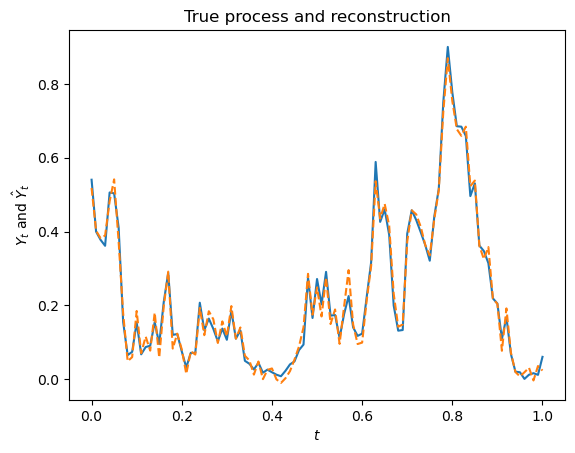

In [138]:
plt.plot(x_axis, target_4)
plt.plot(x_axis, Y_pred_5, '--')
plt.title("True process and reconstruction")
plt.xlabel("$t$")
plt.ylabel("$Y_t$ and $\hat{Y}_t$")
plt.show()

### Simulating n_sim times and testing out of sample with Gaussians - $g_7$ to $g_{12}$

Again, we define the following functions for a general $x = \begin{pmatrix}
x_1\\
x_2\\
x_3\\
x_4
\end{pmatrix} \in \mathbb{R}^4$:
\begin{align}
     & g_7(x) = x_1 \\ \nonumber
     & g_8(x) = x_2 + x_3 \\ \nonumber
    & g_9(x) = x_1 \cdot x_4 \\ \nonumber
    & g_{10}(x) = sin(x_3^2) \\ \nonumber
    & g_{11}(x) = x_1^2+x_3^3 \\ \nonumber
    & g_{12}(x) = x_2^2 \cdot cos(x_4).
\end{align}

We will do an analogous investigation using this process now. Therefore, fix $x_0 = \mathbf{1}, \mu = \mathbf{1}, \Sigma = \mathbb{I}_k, \Theta_{i,j} = i/j$ for the process \cite{compagnoni2021empirics}.

Due to the higher non-triviality of some test functions, we do not try out the same parameter combinations for all of them. Namely, for $g_7$ and $g_8$, we fix $N_{train}=200, N_{test}=100, N_{steps}=101, \lambda_{ridge}=0.01$ vary $k$ from the set $\{10, 20, 50, 100, 200 \}$. For the rest of the functions, we fix $N_{train}=10000, N_{test}=100, N_{steps}=101, \lambda_{ridge}=0.001$ vary $k$ from the set $\{250, 500 \}$.

#### Set the target function:

In [139]:
target_func = g7

#### Set the training parameters:

In [140]:
n_sim_4 = 100
k_4 = 250
A_4 = np.random.normal(0, 1, size=(4, k_4, k_4))
b_4 = np.random.normal(0, 1, size=(4,k_4))
Y_big_4 = np.zeros((N*n_sim_4, 4))
target_big_4 = np.zeros(N*n_sim_4)
Z_big_4 = np.zeros((N*n_sim_4, k_4))
#Y_big_4[0:N,] = np.ones((N,4))
Y_big_4[0:N,].shape

(101, 4)

In [141]:
for iter in range(n_sim_4):
    
    Y_4 = np.zeros((N,4))
    Y_4[0] = y0_4
    brow_4 = np.zeros((N+1,4))
    
    
    br_4 = Brownian()

    for i in range(4):
        brow_4[:,i] = br_4.gen_normal(N+1)
    db_4 = np.diff(brow_4, axis = 0)
    
    for i in range(N-1):
        Y_4[i+1] = Y_4[i] + (mu_4 - theta_4 @ Y_4[i]) * step + sigma_4 @ db_4[i]
        
    dY_4 = np.diff(Y_4, axis = 0)
    Z_4 = np.zeros((N, k_4))
    Z_4[0][0] = 1
    
    for i in range(N-1):
        auxiliary = 0
        for j in range(4):
            auxiliary += sigm_v(A_4[j]@Z_4[i] + b_4[j])*dY_4[i][j]
        Z_4[i+1] = Z_4[i] + auxiliary
        
        
        
        
    Y_big_4[iter*N:(iter+1)*N,:] = Y_4
    Z_big_4[iter*N:(iter+1)*N,:] = Z_4
    
    target_4 = target_func(Y_4)
    target_big_4[iter*N:(iter+1)*N] = target_4

In [142]:
model4 = Ridge(alpha=0.001)
model4.fit(Z_big_4, target_big_4)

Ridge(alpha=0.001)

In [143]:
r_sq_4 = model4.score(Z_big_4, target_big_4)
print(f"coefficient of determination: {r_sq_4}")

coefficient of determination: 0.9988357724312493


In [144]:
print(f"intercept: {model4.intercept_}")

intercept: 1.0087750560598396


In [145]:
print(f"coefficients: {model4.coef_}")

coefficients: [-5.61081517e-03 -8.13623106e-04 -1.98428115e-02  1.79169929e-03
 -2.53446788e-02 -1.06604842e-02 -1.32680776e-03  1.12474460e-02
 -1.01927429e-02  1.24351463e-02 -1.65608071e-02  1.52297987e-03
 -4.93907863e-03 -2.96845351e-02  1.67659139e-02 -1.02063018e-03
  5.63357011e-02 -2.05308821e-02 -5.11976101e-03  1.04490704e-02
  8.47497327e-03  1.41701883e-02  5.03922914e-02 -2.70895511e-02
  2.04458006e-03 -2.34602233e-02 -6.02827847e-03  1.61094918e-02
 -9.36271315e-04  6.39133982e-03 -2.18496744e-02  1.43421480e-03
 -2.42604858e-03  9.41067332e-03  1.30976666e-02 -3.13113092e-02
  2.65929165e-03  5.42618634e-03  4.95768567e-03  3.25059762e-03
  2.85565558e-02 -3.37472897e-03  6.28936751e-03  6.61585534e-03
 -2.47806414e-02  6.33868823e-02 -8.76827531e-03  2.50395329e-03
 -1.13874937e-02 -1.88372902e-03 -3.55535652e-02 -1.37849958e-02
 -6.23949134e-02 -8.16384647e-03 -3.63217921e-04  4.35967480e-03
  9.33614572e-03  1.58060135e-02 -2.28851793e-02  1.31221838e-02
  1.5578935

#### Set the testing parameters:

In [146]:
n_test_4 = 100

In [147]:
error_list_4 = []
for iter_er_4 in range(n_test_4):    
    Y_4 = np.zeros((N,4))
    Y_4[0] = y0_4
    brow_4 = np.zeros((N+1,4))
        

    br_4 = Brownian()
    
    for i in range(4):
        brow_4[:,i] = br_4.gen_normal(N+1)
    db_4 = np.diff(brow_4, axis = 0)

    for i in range(N-1):
            Y_4[i+1] = Y_4[i] + (mu_4 - theta_4 @ Y_4[i]) * step + sigma_4 @ db_4[i]
        
    dY_4 = np.diff(Y_4, axis = 0)
    Z_4 = np.zeros((N, k_4))
    Z_4[0][0] = 1
    
    for i in range(N-1):
        auxiliary = 0
        for j in range(4):
            auxiliary += sigm_v(A_4[j]@Z_4[i] + b_4[j])*dY_4[i][j]
        Z_4[i+1] = Z_4[i] + auxiliary
    target_4 = target_func(Y_4)
    Y_pred_4 = model4.predict(Z_4)
    error_list_4.append(np.linalg.norm(target_4-Y_pred_4)/np.linalg.norm(target_4))

### The average $L^2$ error

In [148]:
np.mean(error_list_4)

0.07964113699642544

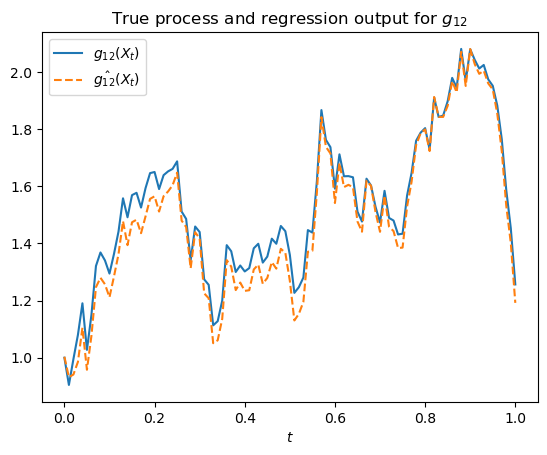

In [149]:
plt.plot(x_axis, target_4)
plt.plot(x_axis, Y_pred_4, '--')
plt.title("True process and regression output for $g_{12}$")
plt.xlabel("$t$")
plt.gca().legend(('$g_{12}(X_t)$','$\hat{g_{12}}(X_t)$'))
plt.show()